# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
!pip  install phik

## Загрузка и подготовка данных

In [2]:
# Необходимые библиотеки
import pandas as pd
import numpy as np
from scipy.stats import bootstrap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from phik import resources, phik_matrix

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
# Импорт данных с обработкой исключений
try:
    geo_data0 = pd.read_csv('geo_data_0.csv')
    geo_data1 = pd.read_csv('geo_data_1.csv')
    geo_data2 = pd.read_csv('geo_data_2.csv')
except:
    geo_data0 = pd.read_csv('/datasets/geo_data_0.csv')
    geo_data1 = pd.read_csv('/datasets/geo_data_1.csv')
    geo_data2 = pd.read_csv('/datasets/geo_data_2.csv')

In [5]:
# Создаем словарь регион-путь
data_path = {
    'Регион1': geo_data0, 
    'Регион2': geo_data1,
    'Регион3': geo_data2
}

In [6]:
# Просматриваем общую информацию по каждому региону
data_info = {region: df.info() for region, df in data_path.items()}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null 

In [7]:
data_desctibe = {region: df.describe() for region, df in data_path.items()}

In [8]:
data_desctibe

{'Регион1':                   f0             f1             f2        product
 count  100000.000000  100000.000000  100000.000000  100000.000000
 mean        0.500419       0.250143       2.502647      92.500000
 std         0.871832       0.504433       3.248248      44.288691
 min        -1.408605      -0.848218     -12.088328       0.000000
 25%        -0.072580      -0.200881       0.287748      56.497507
 50%         0.502360       0.250252       2.515969      91.849972
 75%         1.073581       0.700646       4.715088     128.564089
 max         2.362331       1.343769      16.003790     185.364347,
 'Регион2':                   f0             f1             f2        product
 count  100000.000000  100000.000000  100000.000000  100000.000000
 mean        1.141296      -4.796579       2.494541      68.825000
 std         8.965932       5.119872       1.703572      45.944423
 min       -31.609576     -26.358598      -0.018144       0.000000
 25%        -6.298551      -8.267985   

In [9]:
data_samples = {region: df.head() for region, df in data_path.items()}

In [10]:
# Отображаем  первые пять строк каждого датасета
data_samples

{'Регион1':       id        f0        f1        f2     product
 0  txEyH  0.705745 -0.497823  1.221170  105.280062
 1  2acmU  1.334711 -0.340164  4.365080   73.037750
 2  409Wp  1.022732  0.151990  1.419926   85.265647
 3  iJLyR -0.032172  0.139033  2.978566  168.620776
 4  Xdl7t  1.988431  0.155413  4.751769  154.036647,
 'Регион2':       id         f0         f1        f2     product
 0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
 1  62mP7  14.272088  -3.475083  0.999183   26.953261
 2  vyE1P   6.263187  -5.948386  5.001160  134.766305
 3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
 4  AHL4O  12.702195  -8.147433  5.004363  134.766305,
 'Регион3':       id        f0        f1        f2     product
 0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
 1  WJtFt  0.262778  0.269839 -2.530187   56.069697
 2  ovLUW  0.194587  0.289035 -5.586433   62.871910
 3  q6cA6  2.236060 -0.553760  0.930038  114.572842
 4  WPMUX -0.515993  1.716266  5.899011  149.600746}

В каждом датасете есть `100 000 записей` и `5 столбцов`:

- `id` — уникальный идентификатор скважины (не нужен для обучения модели),
- `f0`, `f1`, `f2` — признаки скважины,
- `product` — целевая переменная (объём нефти в тысячах баррелей).

Данные чистые, без пропусков. Типы данных корректные.

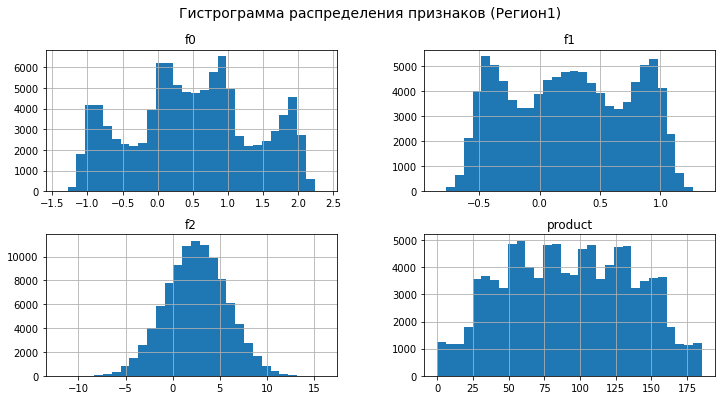

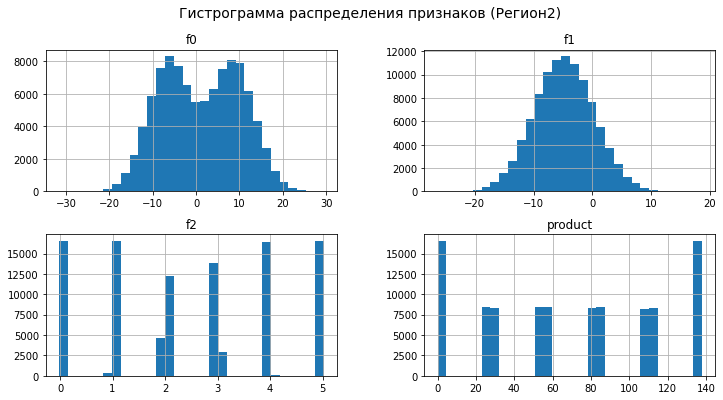

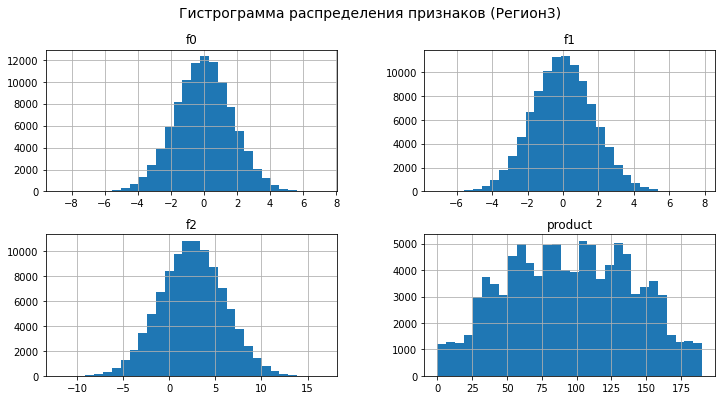

In [11]:
for region, df in data_path.items():
    df.drop(columns=['id']).hist(figsize=(12,6), bins=30)
    plt.suptitle(f'Гистрограмма распределения признаков ({region})', fontsize=14)

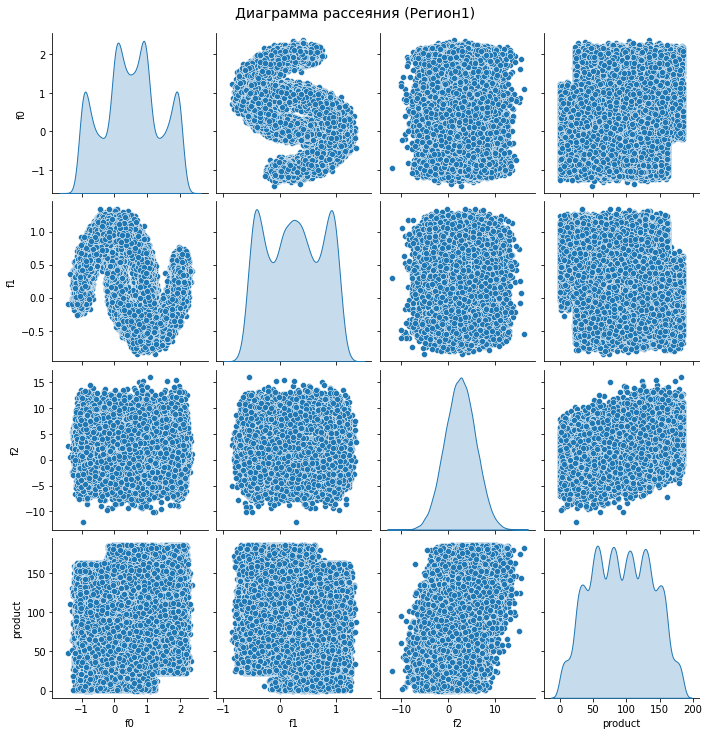

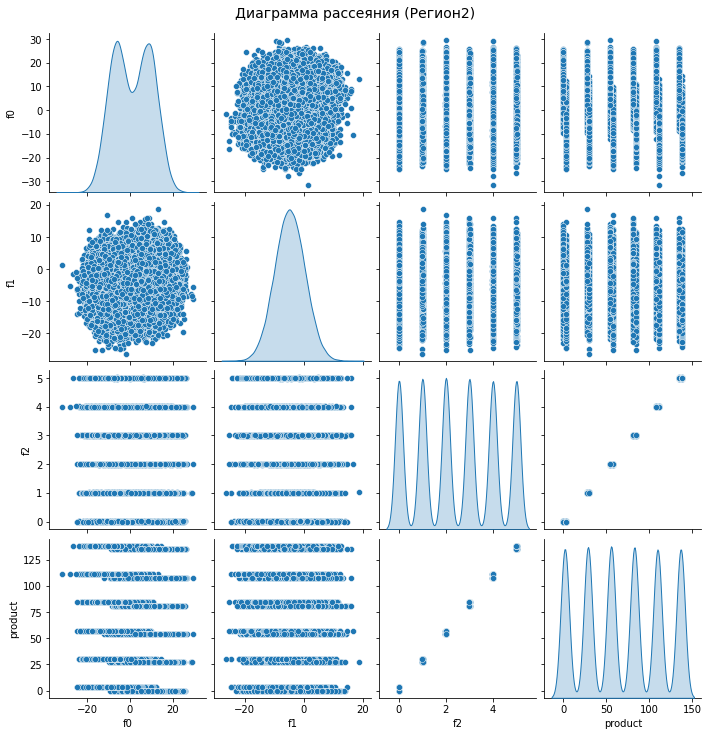

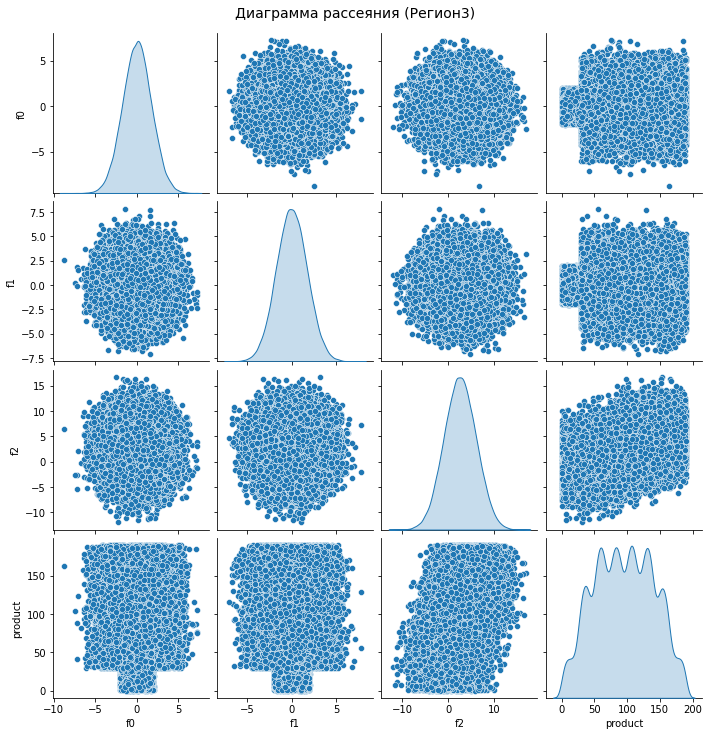

In [12]:
for region, df in data_path.items():
    sns.pairplot(df.drop(columns=['id']), diag_kind='kde')
    plt.suptitle(f'Диаграмма рассеяния ({region})', y=1.02, fontsize=14)
    plt.show()

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


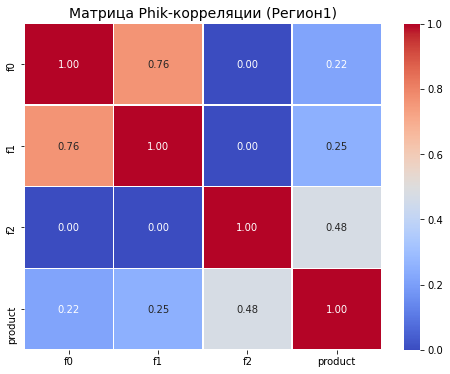

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


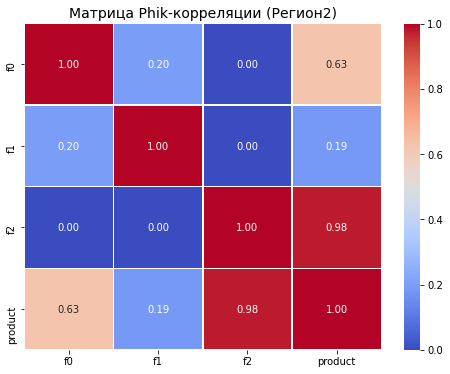

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


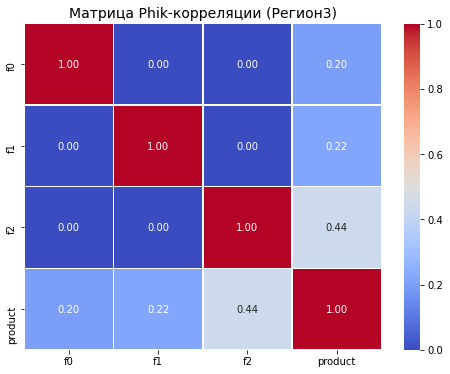

In [13]:
for region, df in data_path.items():
        df = df.drop(columns=['id'])
        phik_matrix_values = df.phik_matrix()

        plt.figure(figsize=(8, 6))
        sns.heatmap(phik_matrix_values, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
        plt.title(f"Матрица Phik-корреляции ({region})", fontsize=14)
        plt.show()

***Выводы по анализу***

***1. Гистограммы распределения признаков:***
- В `Регионе 1` признаки f0 и f1 имеют многомодальное распределение, что может указывать на наличие нескольких кластеров в данных.
- В `Регионе 2` распределение f2 и product имеет дискретную структуру — вероятно, признак содержит категориальные данные или данные, полученные с округлением.
- В `Регионе 3` все признаки распределены нормально, что благоприятно для линейной модели.

***2. Диаграммы рассеяния:***
- В `Регионе 1` видны S-образные и нелинейные зависимости между f0 и f1, что может ухудшать качество линейной модели.
- В `Регионе 2` признаки f2 и product разделены на четкие группы, что указывает на влияние каких-то скрытых факторов.
- В `Регионе 3` признаки более равномерно распределены, что делает регион наиболее предсказуемым для линейной регрессии.

***3. Матрица PhiK-корреляции:***
- В `Регионе 1` f0 и f1 имеют сильную корреляцию (`0.76`), что может указывать на мультиколлинеарность.
- В `Регионе 2` f2 и product сильно коррелированы (`0.98`), что делает f2 хорошим предиктором.
- В `Регионе 3` максимальная корреляция f2 и product составляет `0.44`, что ниже, чем в других регионах.

## Обучение и проверка модели

In [14]:
# Словари для хранения предсказаний и истинных значений
predictions = {}
true_values = {}
model_results = {}

In [15]:
# Обучение модели и сохранение результатов
for region, df in data_path.items():
    df = df.drop(columns=['id'])

    X = df.drop(columns=['product'])
    y = df['product']

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_valid)

    rmse = mean_squared_error(y_valid, y_pred, squared=False)

    # Сохраняем предсказания и истинные значения для дальнейших расчетов
    predictions[region] = y_pred
    true_values[region] = y_valid

    model_results[region] = {
        "Средний запас предсказанного сырья": y_pred.mean(),
        "RMSE модели": rmse
    }

In [16]:
model_results

{'Регион1': {'Средний запас предсказанного сырья': 92.39879990657768,
  'RMSE модели': 37.75660035026169},
 'Регион2': {'Средний запас предсказанного сырья': 68.71287803913762,
  'RMSE модели': 0.890280100102884},
 'Регион3': {'Средний запас предсказанного сырья': 94.77102387765939,
  'RMSE модели': 40.145872311342174}}

***Анализ результатов моделей***

1. Средний запас предсказанного сырья:

 - Регион 0: 92.39 тыс. баррелей
 - Регион 1: 68.71 тыс. баррелей
 - Регион 2: 94.77 тыс. баррелей


2. RMSE модели:

 - Регион 0: 37.75 тыс. баррелей
 - Регион 1: 0.89 тыс. баррелей
 - Регион 2: 40.14 тыс. баррелей

***Вывод:***

- В регионе 1 модель предсказывает запасы намного точнее (низкое RMSE).
- В регионе 2 средний предсказанный запас наибольший, но ошибка тоже самая высокая.
- В регионе 0 ситуация средняя.

## Подготовка к расчёту прибыли

In [17]:
BUDGET = 10000000000
BARREL_PRICE = 450_000
POINTS_ALL = 500# Всего скважин исследуется в регионе
POINTS_ML = 200 # Количество разрабатываемых скважин

In [18]:
# Рассчитываем минимальный объём сырья для безубыточности
min_product_for_profit = BUDGET / (POINTS_ML * BARREL_PRICE)
min_product_for_profit

111.11111111111111

***Анализ минимального запаса для безубыточности***

Минимальный запас для безубыточности: `111.11 тыс. баррелей`.

In [19]:
# Сравниваем с предсказанным средним запасом
profit_comparison = {
    region: {
        "Средний запас предсказанного сырья": results["Средний запас предсказанного сырья"],
        "Минимально необходимый запас": min_product_for_profit,
        "Запас > Минимального": results["Средний запас предсказанного сырья"] > min_product_for_profit
    }
    for region, results in model_results.items()
}

In [20]:
profit_comparison

{'Регион1': {'Средний запас предсказанного сырья': 92.39879990657768,
  'Минимально необходимый запас': 111.11111111111111,
  'Запас > Минимального': False},
 'Регион2': {'Средний запас предсказанного сырья': 68.71287803913762,
  'Минимально необходимый запас': 111.11111111111111,
  'Запас > Минимального': False},
 'Регион3': {'Средний запас предсказанного сырья': 94.77102387765939,
  'Минимально необходимый запас': 111.11111111111111,
  'Запас > Минимального': False}}

***Средние предсказанные запасы во всех регионах ниже этого значения:***
 - Регион 0: 92.40 тыс. баррелей (ниже порога)
 - Регион 1: 68.71 тыс. баррелей (значительно ниже порога)
 - Регион 2: 94.77 тыс. баррелей (ниже порога)

***Вывод:***

На данный момент разработка в любом регионе убыточна, если рассматривать средний запас.
Но это средний запас, а мы будем выбирать 200 лучших скважин, возможно ситауция изменится.

## Расчёт прибыли и рисков 

In [21]:
# Функция для расчета прибыли по 200 лучшим скважинам
def calculate_profit(y_true, y_pred):
    # Выбираем 200 скважин с наибольшими предсказаниями
    best_indices = np.argsort(y_pred)[-POINTS_ML:]
    
    # Считаем реальный объем добытого сырья для этих скважин
    selected_oil = y_true.iloc[best_indices].sum()
    
    # Рассчет прибыли
    revenue = selected_oil * BARREL_PRICE
    profit = revenue - BUDGET
    
    return profit

In [22]:
# Расчет прибыли для каждого региона
profit_results = {}

In [23]:
# Рассчитываем прибыль для каждого региона
for region in data_path.keys():
    y_valid = true_values[region]
    y_pred = predictions[region]

    profit_results[region] = calculate_profit(y_valid, y_pred)

In [24]:
profit_results

{'Регион1': 3359141114.462179,
 'Регион2': 2415086696.681511,
 'Регион3': 2598571759.374111}

***Анализ прибыли по регионам***

После выбора 200 лучших скважин прибыль получилась следующая:

 - Регион 0: `3.35 млрд рублей`
 - Регион 1: 2.41 млрд рублей
 - Регион 2: 2.59 млрд рублей

In [25]:
# Функция для анализа прибыли через bootstrap
def bootstrap_profit(y_true, y_pred, n_samples=1000):
    profits = []
    rng = np.random.default_rng(42)
    
    for _ in range(n_samples):
        sample_indices = rng.choice(len(y_pred), size=POINTS_ALL, replace=True) # Тут внес корректировку. Плюс поставил replace=True, чтобы сэмплирование происходило с повторениями
        sample_y_true = y_true.iloc[sample_indices]
        sample_y_pred = y_pred[sample_indices]
        profit = calculate_profit(sample_y_true, sample_y_pred)
        profits.append(profit)
    
    # Вычисляем доверительный интервал 95%
    lower_bound = np.percentile(profits, 2.5)
    upper_bound = np.percentile(profits, 97.5)
    
    # Рассчитываем вероятность убытков
    risk = np.mean(np.array(profits) < 0)
    
    return np.mean(profits), (lower_bound, upper_bound), risk

In [26]:
# Словарь для хранения результатов bootstrap
bootstrap_results = {}

In [27]:
# Оценка прибыли через bootstrap по регионам
for region in data_path.keys():
    y_valid = true_values[region]
    y_pred = predictions[region]

    mean_profit, conf_interval, risk = bootstrap_profit(y_valid, y_pred)

    bootstrap_results[region] = {
        "Средняя прибыль": mean_profit,
        "95% доверительный интервал": conf_interval,
        "Риск убытков": risk
    }

In [28]:
bootstrap_results

{'Регион1': {'Средняя прибыль': 413352512.26892716,
  '95% доверительный интервал': (-94461593.07796635, 928204104.3402419),
  'Риск убытков': 0.045},
 'Регион2': {'Средняя прибыль': 457662177.0488867,
  '95% доверительный интервал': (62483747.51019917, 843671666.983143),
  'Риск убытков': 0.015},
 'Регион3': {'Средняя прибыль': 395277264.93101853,
  '95% доверительный интервал': (-128811942.29702295, 881655970.1336404),
  'Риск убытков': 0.068}}

**После применения bootstrap (1000 выборок):**

1. Средняя прибыль:

 - Регион 0: 0.41 млрд рублей
 - Регион 1: 0.46 млрд рублей
 - Регион 2: 0.39 млрд рублей

2. 95% доверительный интервал:

 - Регион 0: (-0.09 - 0.93 млрд)
 - Регион 1: (0.06 - 0.84 млрд)
 - Регион 2: (-0.13 - 0.88 млрд)

***Риск убытков:*** 

 - Регион 0: 4.5% (Риск выше 2.5%)
 - Регион 1: 1.5% (Проходит условие)
 - Регион 2: 6.8% (Риск выше 2.5%)

***Вывод***

`Регион 1` и `Регион 3` имеют слишком высокий риск убытков (`>2.5%`), поэтому их нельзя рекомендовать.

`Регион 2:`

 - Средняя прибыль — 0.46 млрд рублей.
 - 95% доверительный интервал — (0.06, 0.84) млрд (в нижней границе прибыль положительная).
 - Риск убытков — всего 1.5% (проходит по условиям).

***Рекомендация:*** Выбрать `Регион 2` для бурения новых скважин.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован